# Introduction

In [40]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances

Lets plot the original dataset, by keeping only three out of four dimensions, so we can see the spread of the data points and which attribute contributes the most to the variance.

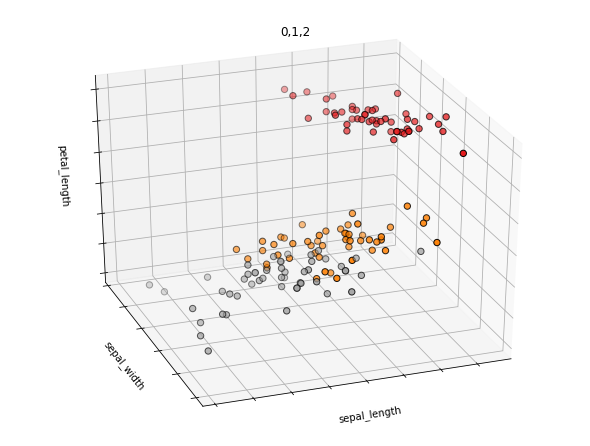

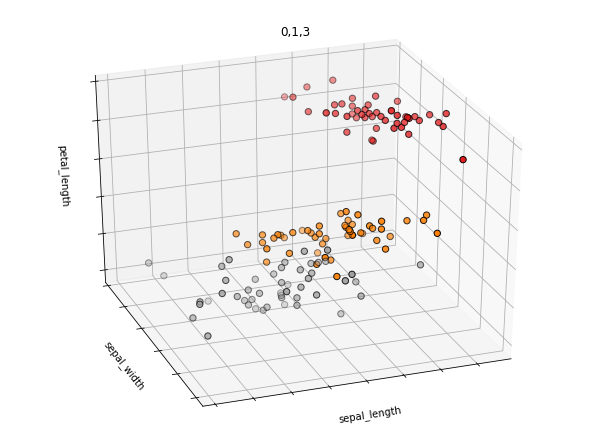

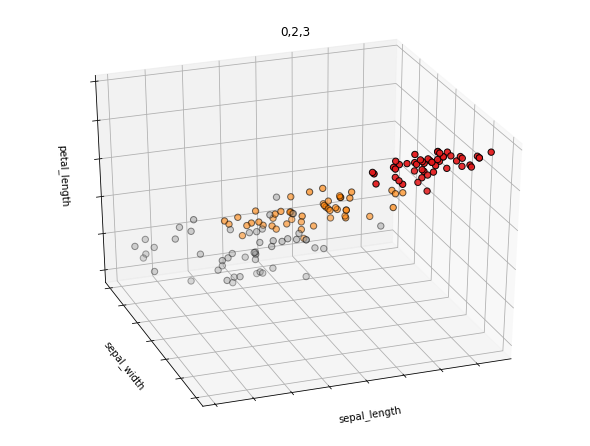

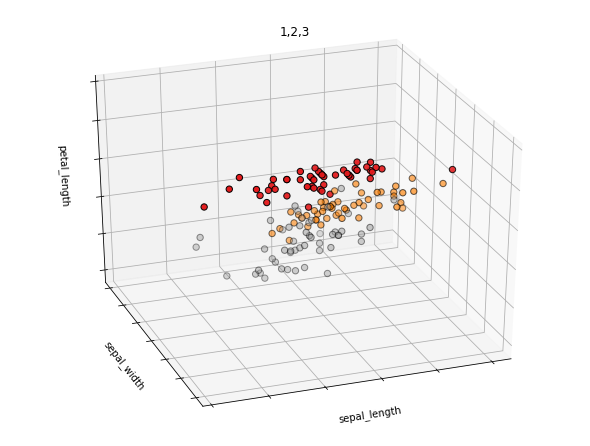

In [41]:
iris = datasets.load_iris()
X = iris.data[:, :4]
y = iris.target

#used to determine which 3 out of four dimensions we use each time
sides = [[0, 1, 2],
         [0, 1, 3],
         [0, 2, 3],
         [1, 2, 3]]

# To getter a better understanding of interaction of the dimensions
for i in range(4):
  fig = plt.figure(i, figsize=(8, 6))
  ax = Axes3D(fig, elev=-150, azim=110)
  X_reduced = X 
  ax.scatter(X_reduced[:, sides[i][0]], X_reduced[:, sides[i][1]], X_reduced[:, sides[i][2]], c=y,
            cmap=plt.cm.Set1, edgecolor='k', s=40)
  ax.set_title(str(sides[i][0]) + "," + str(sides[i][1]) + "," + str(sides[i][2]))
  ax.set_xlabel("sepal_length")
  ax.w_xaxis.set_ticklabels([])
  ax.set_ylabel("sepal_width")
  ax.w_yaxis.set_ticklabels([])
  ax.set_zlabel("petal_length")
  ax.w_zaxis.set_ticklabels([])

plt.show()

Now, lets see how the data will be after performing PCA and plotting the first three Principal Components

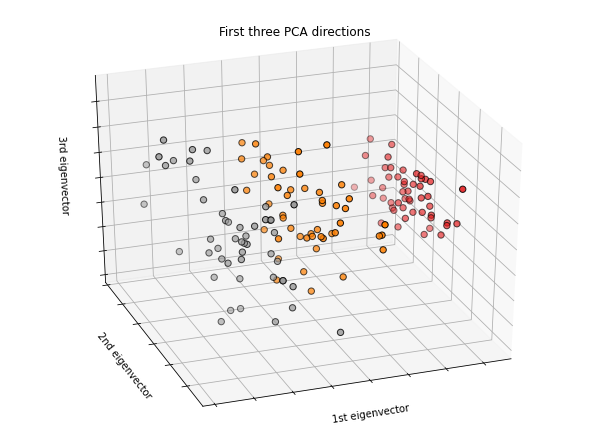

In [42]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

We can see that data points are more evenly spread after performing PCA, and each cluster of data can be dishtinguished easier than just keeping any random three attributes from the original dataset.

Below we can see the variance expained by each of the four attributes of our dataset.

In [43]:
X = iris.data
y = iris.target
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.92461872 0.05306648 0.01710261 0.00521218]


We can see that most of the variance can be explained by the first component, so if we end up not using it, we will loose a lot of information, resulting into a dataset that looks like blendered points, points that dont seem like thay have any relation among them, or else, clusters that represent the result we want will be harder to form.

This can be seen below, were we use all the other components but the first one.

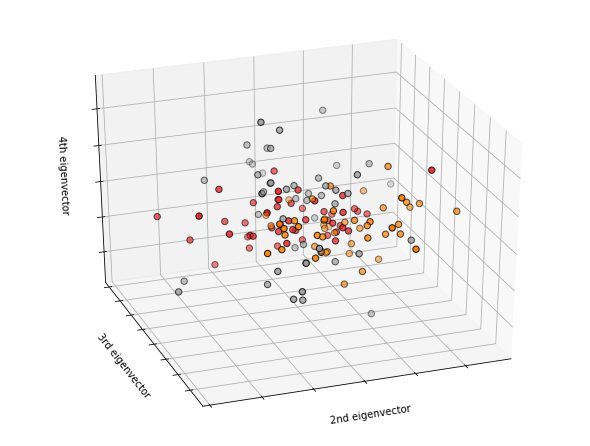

In [44]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
#X_reduced = PCA(n_components=4).fit_transform(iris.data)
ax.scatter(X_reduced[:, 1], X_reduced[:, 2], X_reduced[:, 3], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("")
ax.set_xlabel("2nd eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("3rd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("4th eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

After performing PCA, we end up with an array with similar dimensions as our original data, but this time it contains weights.

We can see below the first instance of the X_reduced array, which we created on the above cell via PCA

In [45]:
X_reduced[1]

array([-2.71414169, -0.17700123, -0.21046427, -0.09902655])

Lets have a look on how these weights were created.

We will create a new array (**X_new**) with our data, by subtracting the mean values from our original dataset.

If we multiply X_new with any of the Components, and sum the results, we will get the corresponding value on the X_reduced array above.

An example is given on the next cell.

In [46]:
#subtract mean values from the original dataset
X_new = X - X.mean(axis=0)

#multiply the values of a particular row, with any of the components we want
first_value = X_new[1]  * pca.components_.T[:,0]

#print all the values and their sum
print(first_value)
print("sum =", sum(first_value))

[-0.34090802  0.00484596 -2.02002929 -0.35805034]
sum = -2.714141687294326


We can see that the absolute **sum** is the exact same number as the fisrt value on the **X_reduced[1]** array above.

If we wanted the second value, we would have done the exact same process, but this time instead of multiplying with **pca.components_.T[:,0]**, we would multiply with **pca.components_.T[:,1]** etc.

The contribution of each feature on the particular example above, can be seen easier on the next cell

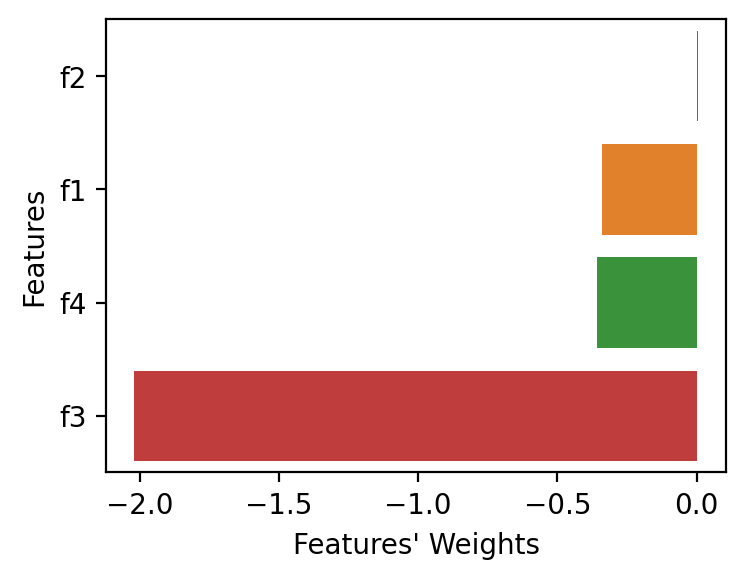

In [47]:
model_weights = pd.DataFrame({"Features": ["f1","f2","f3","f4"], "Features' Weights": list(X_new[1]* pca.components_.T[:,0])})
model_weights = model_weights.sort_values(by="Features' Weights", ascending=False)
model_weights = model_weights[(model_weights["Features' Weights"] != 0)]
plt.figure(num=None, figsize=(4, 3), dpi=200, facecolor='w', edgecolor='k')
sns.barplot(x="Features' Weights", y="Features", data=model_weights)
plt.show()

We can see that the third feature contributes the most in this case.

Lets now see which feature contributes the most among all of our dataset.

More specifically, for each instance of our dataset, we keep track of the features that contributed the most. For example, on the cell above, we have the instance on the position 1, and we multiply it with the first component, with a result that the third (f3) feture contributed the most. We do the same for the rest three components and we end up with four fetures, one for each component. Finaly we keep the one out of these four fetures that appears the most times.

We do the same process for the rest instanses of our dataset.

In [48]:
all_counter = np.zeros(4)
for i in range(len(X_new)):
  counter = np.zeros(4)
  for j in range(4):
    arr = X_new[i]* pca.components_.T[:,j] 
    arr = abs(arr)
    counter[np.argmax(arr)] += 1
  all_counter[np.argmax(counter)] += 1
print(all_counter)

[65. 30. 50.  5.]


We notice that out of the 150 data instances, on 65 of those the first feature contributed the most, the second feature contributed the most on 30 instances, the third on 50, and the fourth on 5.

Below we can see the plot using only the fisrt and third feature.

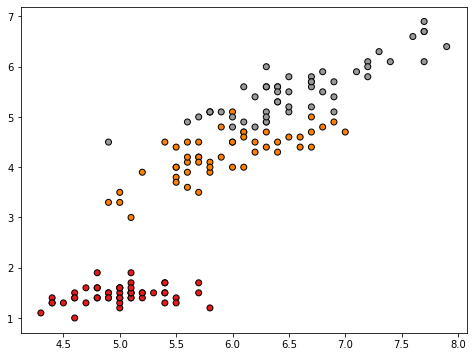

In [49]:
plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the points
plt.scatter(X[:, 0], X[:, 2], c=y, cmap=plt.cm.Set1,
            edgecolor='k')


# **Flowchart implementation**

We will try to implement the flowchart below step by step.

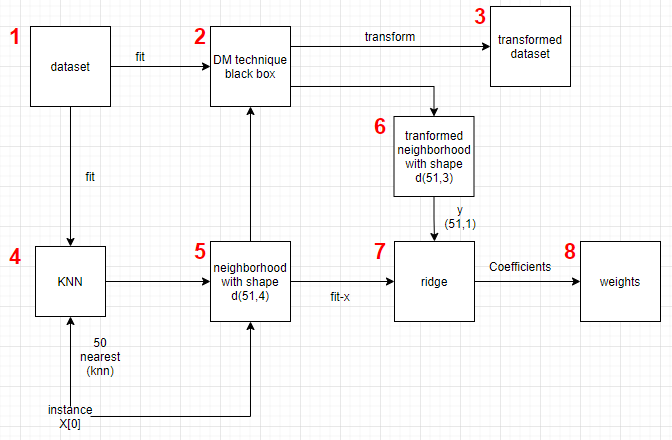

We first initialise our data and we perform PCA in order to get the transformed dataset **(steps 1, 2, 3)**.

In [50]:
initial_data = iris.data[:, :4]
initial_predictions = iris.target
pca = PCA(n_components=3)
Transformed_dataset = pca.fit_transform(iris.data)

In [51]:
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143]])

In the next cell, we find the 50 nearest neighbors for each sample of the dataset. Each sample is also included in the 50 nearest neighbros **(step 4)**.

**neighbs_for_each_sample** will be a (150,50) shaped list. Row 0 will contain the 50 nearest neighbors of the sample 0, etc. Neighbors are defined by their index position in the initial_data list, and its not a (1,4) shaped list. In the next cell we will get access of these features. 

In [52]:
neighbs_for_each_sample = []
for i in range(len(initial_data)):
  neigh = NearestNeighbors(n_neighbors=50)
  neigh.fit(initial_data)
  All_50_neighbors = neigh.kneighbors(initial_data[i].reshape(1, -1), return_distance=False)[0]
  #All_50_neighbors = np.delete(All_50_neighbors, 0, 0)
  neighbs_for_each_sample.append(All_50_neighbors)

Since we already have the indexes of the nearest neighbors, now we can access all their features **(step 5)**. 

**total_neighbs** will be a list with 150 2d lists, each 2d list will have a shape of (50,4) and will contain the features of all neighbors. For example row 0 will contain the four features for all 50 nearest neighbors of sample 0 (the first 5 instances of this example are also printed below for better understanding).

In [53]:
total_neighbs = []
for i in range(len(neighbs_for_each_sample)):
  local_neighb = [] 
  for sample in neighbs_for_each_sample[i]:
    local_neighb.append(initial_data[sample])
  total_neighbs.append(local_neighb)

for i in range(5):
  print(total_neighbs[0][i])

[5.1 3.5 1.4 0.2]
[5.1 3.5 1.4 0.3]
[5.  3.6 1.4 0.2]
[5.1 3.4 1.5 0.2]
[5.2 3.4 1.4 0.2]


After getting the 50 nearest neighbors of each sample, we now apply PCA on them.

**Transformed_total_neighbs** will be a list with 150 2d lists, each 2d list will have a shape of (50,3). It is the PCA result of the total_neighbs list that we created on the cell above **(step 6)**.

In [54]:
Transformed_total_neighbs = []
for i in range(len(total_neighbs)):
  Transformed_total_neighbs.append(PCA(n_components=3).fit_transform(total_neighbs[i]))

Below we transform our data set into numpy arrays so we can use them to fit our model

In [55]:
initial_data_np = np.array(initial_data)
total_neighbs_np = np.array(total_neighbs)
Transformed_total_neighbs_np = np.array(Transformed_total_neighbs)

Here we calculate the euclidean distances between each sample and their neighbors

total_distances will be a (150, 50) shaped list.

In [56]:
total_distances = []
for sample in range(len(initial_data)):
  total_distances.append(euclidean_distances(initial_data_np[sample].reshape(1, -1), total_neighbs_np[sample].reshape(-1, 4))[0])

In [57]:
total_distances[0]

array([0.        , 0.1       , 0.14142136, 0.14142136, 0.14142136,
       0.14142136, 0.17320508, 0.17320508, 0.2236068 , 0.24494897,
       0.3       , 0.3       , 0.31622777, 0.33166248, 0.36055513,
       0.37416574, 0.37416574, 0.37416574, 0.38729833, 0.41231056,
       0.43588989, 0.45825757, 0.45825757, 0.46904158, 0.46904158,
       0.50990195, 0.51961524, 0.53851648, 0.53851648, 0.53851648,
       0.54772256, 0.54772256, 0.58309519, 0.59160798, 0.59160798,
       0.59160798, 0.6164414 , 0.6164414 , 0.6244998 , 0.64807407,
       0.64807407, 0.74161985, 0.76811457, 0.80622577, 0.8660254 ,
       0.88317609, 0.92195445, 0.99498744, 1.1045361 , 1.34907376])

We pass the distances through a kernel function 

https://arxiv.org/pdf/2104.06057.pdf page 10, equation 10

In [58]:
def Kernel(array):
  normilised_distances = []
  d = 4
  for sample in range(len(array)):
    local_dist = []
    for dist in range(len(array[0])):
      power = -dist * math.log(d)/2
      normilised = math.pow(math.e,power) * math.log(d)
      local_dist.append(normilised)
    normilised_distances.append(local_dist)
  return normilised_distances

In [59]:
normilised_distances = Kernel(total_distances)
print(normilised_distances[0])

[1.3862943611198906, 0.6931471805599453, 0.3465735902799727, 0.17328679513998635, 0.08664339756999317, 0.04332169878499659, 0.021660849392498304, 0.01083042469624915, 0.005415212348124575, 0.0027076061740622876, 0.0013538030870311438, 0.0006769015435155717, 0.00033845077175778616, 0.00016922538587889308, 8.461269293944654e-05, 4.230634646972327e-05, 2.1153173234861632e-05, 1.0576586617430816e-05, 5.288293308715408e-06, 2.644146654357704e-06, 1.3220733271788516e-06, 6.610366635894258e-07, 3.305183317947129e-07, 1.6525916589735645e-07, 8.262958294867836e-08, 4.1314791474339105e-08, 2.065739573716959e-08, 1.0328697868584776e-08, 5.164348934292397e-09, 2.5821744671461932e-09, 1.2910872335730989e-09, 6.455436167865483e-10, 3.227718083932747e-10, 1.6138590419663762e-10, 8.069295209831867e-11, 4.0346476049159405e-11, 2.0173238024579667e-11, 1.0086619012289851e-11, 5.043309506144916e-12, 2.5216547530724624e-12, 1.260827376536229e-12, 6.304136882681156e-13, 3.1520684413405714e-13, 1.57603422067

Now we will perform the **step 7** of the flowchart. We will use the **Ridge** linear model from sklearn. 

In order to fit the model, we will use as training data the **total_neighbs** for each sample, and as target values we will use the **Transformed_total_neighbs** three times for each sample, one for each of its column (there are 3 columns/features after performing PCA).

**Result:** for each sample we will have 3 lists with lenght = number_of_features = 4

**total_coef** will be a list with 150 2d lists **(step 8)**. There will be a 2d list for each one of our samples, and every 2d list will have a shape of (3,4), 3 because we fit the model three times, and 4 because every sample has four features.

An example output is given below, showing the final coeficients/weights (array of shape (3,4) ) of the first sample.

In [60]:
total_coef = []
for sample in range(len(total_neighbs_np)):
  local_coef = []
  for column in range(3):
    clf = Ridge(alpha=10).fit(total_neighbs_np[sample], Transformed_total_neighbs_np[sample,:,column])#, normilised_distances[sample])
    local_coef.append(clf.coef_)
  total_coef.append(local_coef)
print(total_coef[0])

[array([0.35912371, 0.39404932, 0.05181934, 0.03411737]), array([-0.09158957,  0.09508067, -0.07507139, -0.02005832]), array([-0.0510634 ,  0.03187177,  0.09661659,  0.02264012])]


# Lets evaluate what we did until now, via the reconstruction error.

We will use a similar process as we did in a previous cell, but this time we will also use the components that our model created (total_ceof).

For each sample, we calculate a value representing its state on the reduced dimension K (we have 3 dimensions in this example), once by using the PCA components, and once by using the components of our linear model.

If we do this process for all 3 dimensions, we will have each sample represented on the reduced dimensions via PCA and via the linear model.

**model_value** ((1, 4) shaped list) is the value after multiplying the sample with the components.

**model_summed_value** ((1, 3) shaped list) its the sum of the model_value on each dimension for one sample.

**model_summed_values** is a list with 150 2d lists, each 2d list is the model_summed_value.

Same process is done by using the PCA components, using PCA_value, PCA_summed_value and PCA_summed_values respectively.

In [61]:
model_summed_values = []
PCA_summed_values = []

for sample in range(len(total_neighbs_np)):
  model_summed_value = []
  PCA_summed_value = []
  for dimension in range(len(total_coef[0])):

      #multiply the values of each sample with  the PCA components and the components we calculated above.
      model_value = X_new[sample] * total_coef[sample][dimension]
      PCA_value = X_new[sample] * pca.components_.T[:,dimension]

      #calculate the sum of both values for each sample
      model_summed_value.append(sum(model_value))
      PCA_summed_value.append(sum(PCA_value))

  model_summed_values.append(model_summed_value)
  PCA_summed_values.append(PCA_summed_value)

After calculating the reduced dimensionality state of each sample for both PCA and Linear model components, we can calculate the absolute error and see how well linear model estimated PCA values .

Below we see the absolute error of the **first** sample.

In [62]:
(abs(PCA_summed_values[0][0]-model_summed_values[0][0]) + abs(PCA_summed_values[0][1]-model_summed_values[0][1]) + abs(PCA_summed_values[0][2]-model_summed_values[0][2]) ) / 3

0.8726515501999649

Lets do the same process for all the samples and get the average value. The lowest the value, the best (Linear model estimated well the PCA weights). 

In [63]:
sum_error = 0
for sample in range(len(total_neighbs_np)):
  sum_error += (abs(PCA_summed_values[sample][0]-model_summed_values[sample][0]) + abs(PCA_summed_values[sample][1]-model_summed_values[sample][1]) + abs(PCA_summed_values[sample][2]-model_summed_values[sample][2]) ) / 3
sum_error/len(total_neighbs_np) 

0.6773673693549748

Instead of the cell above, we can simply use the mean_absolute_error from sklearn as shown below.

In [64]:
mean_absolute_error(PCA_summed_values, model_summed_values)

0.6773673693549749

**Error visualisation**

Below we can see the comparison of the values created using the linear model and PCA respectively.

In [65]:
#multiply the values of a particular row, with any of the components we want
model_value = X_new[0] * total_coef[0][2]
pca_value = X_new[0]  * pca.components_.T[:,2]

#print all the values and their sum
print(model_value)
print("sum =", sum(model_value))
print(pca_value)
print("sum =", sum(pca_value))

[ 0.03795713  0.01410857 -0.22782192 -0.02262503]
sum = -0.19838125326132608
[ 0.43264219  0.26467519 -0.17976467 -0.54546754]
sum = -0.027914827589414104


Text(0, 0.5, 'values')

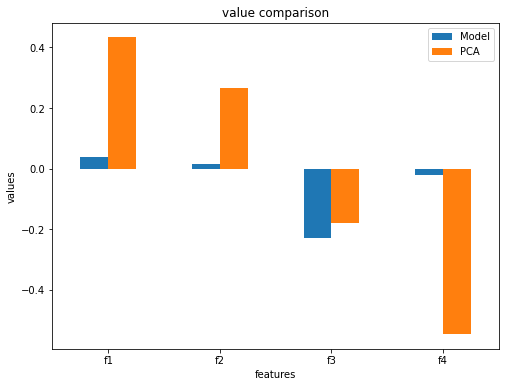

In [66]:
plotdata = pd.DataFrame({
    "Model":model_value,
    "PCA":pca_value,
    }, 
    index=["f1","f2","f3","f4"]
)
plt.rcParams["figure.figsize"] = [8, 6]
plotdata.plot(kind="bar", rot=0)
plt.title("value comparison")
plt.xlabel("features")
plt.ylabel("values")

In [67]:
!python --version

Python 3.7.10


In [68]:
import site, pprint
pprint.pprint(site.getsitepackages())

['/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.7/dist-packages']


In [69]:
!python -m site --user-site

/root/.local/lib/python3.7/site-packages


In [70]:
!pip install lime==0.2.0.1

In [71]:
!mv lime_tabular.py /usr/local/lib/python3.7/dist-packages/lime/

In [72]:
ls /usr/local/lib/python3.7/dist-packages/lime/

bundle.js       __init__.py      lime_text.py        utils/
discretize.py   lime_base.py     __pycache__/        webpack.config.js
exceptions.py   lime_image.py    submodular_pick.py  wrappers/
explanation.py  lime_tabular.py  tests/


**README**

the comments below are the ones we discussed the previous week

If i remember correctly, we will do a similar process as we did above, but this time we will use neighbours from the give_me_the_neighbourhood function.

we would have 3 explainers, one for each column of the transposed data. On trello it has mode="classification", but during the meeting we put "regression", i tried both but got similar outputs.

I tried to get the neighbours but the function requires the predict_fn parameter,  i dont remember if we mentioned it as a parameter, i used Ridge, since thats what we used on the model we did above, and just so i could check that the code runs.

On trello, the function give_me_the_neighbourhood has two parameters, there is a similar function on the github repo, that doesnt require the predict_fn but its in another file.

When i run the code for the diffirent explainers, i get the 50 neighbours, but they are the same regardless the explainer.

In [78]:
from lime.lime_tabular import LimeTabularExplainer

#explainer_0 =  LimeTabularExplainer(initial_data, y, discretize_continuous = False, mode = "regression" )
#explainer_1 =  LimeTabularExplainer(initial_data, y,  discretize_continuous = False, mode = "regression" )
#explainer_2 =  LimeTabularExplainer(initial_data, y,  discretize_continuous = False, mode = "regression" )
explainer_0 =  LimeTabularExplainer(training_data=initial_data, training_labels = Transformed_dataset[0], discretize_continuous=False, mode="classification",random_state=0)
explainer_1 =  LimeTabularExplainer(training_data=initial_data, training_labels = Transformed_dataset[1], discretize_continuous=False, mode="classification",random_state=0)
explainer_2 =  LimeTabularExplainer(training_data=initial_data, training_labels = Transformed_dataset[2], discretize_continuous=False, mode="classification",random_state=0)

In [79]:
a = explainer_0.give_me_the_neighbourhood(initial_data[0], Ridge, num_samples=50)
b = explainer_1.give_me_the_neighbourhood(initial_data[0], Ridge, num_samples=50)
c = explainer_2.give_me_the_neighbourhood(initial_data[0], Ridge, num_samples=50)
print(a[0])
print("")
print(b[0])

[[-0.90068117  1.01900435 -1.34022653 -1.3154443 ]
 [ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323  0.33367433]
 [ 1.49407907 -0.20515826  0.3130677  -0.85409574]
 [-2.55298982  0.6536186   0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567  0.04575852 -0.18718385]
 [ 1.53277921  1.46935877  0.15494743  0.37816252]
 [-0.88778575 -1.98079647 -0.34791215  0.15634897]
 [ 1.23029068  1.20237985 -0.38732682 -0.30230275]
 [-1.04855297 -1.42001794 -1.70627019  1.9507754 ]
 [-0.50965218 -0.4380743  -1.25279536  0.77749036]
 [-1.61389785 -0.21274028 -0.89546656  0.3869025 ]
 [-0.51080514 -1.18063218 -0.02818223  0.42833187]
 [ 0.06651722  0.3024719  -0.63432209 -0.36274117]
 [-0.67246045 -0.35955316 -0.81314628 -1.7262826 ]
 [ 0.17742614 -0.40178094 -1.63019835  0.46278226]
 [-0.90729836  0.0519454   0.72909056  0.12898291]
 [ 1.13940068 -1.23482582  0.40234164 -0.68481009]
 [-0.87079715 -0.57884966 -0.31